In [1]:
import pandas as pd

df = pd.read_csv('cleaned_crime.csv')

***IMPORT LIBRARIES***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

***HAVING DAILY CRIME COUNT***

In [9]:
df['Date_Rptd'] = pd.to_datetime(df['Date_Rptd'], errors='coerce')

df = df[df['Date_Rptd'] < '2025-01-01']
ts = (df
      .groupby(df['Date_Rptd'].dt.date)
      .size()
      .rename_axis('date')
      .to_frame('crime_count')
      .asfreq('D')
      .fillna(method='ffill')
)

ts.head()

/tmp/ipython-input-9-677964667.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')  # forward‑fill gaps


,crime_count
date,
2020-01-01,354
2020-01-02,398
2020-01-03,403
2020-01-04,436
2020-01-05,420


***ADF STAT AND P-VALUE***

In [10]:
def adf_test(series, title=''):
    stat, p, *_ = adfuller(series.dropna())
    print(f"{title} – ADF stat: {stat:.3f}, p‑value: {p:.3g}")
    return p

p_val = adf_test(ts['crime_count'], 'Original series')

if p_val > 0.05:
    ts_diff = ts['crime_count'].diff().dropna()
    adf_test(ts_diff, '1st difference')
    d = 1
else:
    ts_diff = ts['crime_count']
    d = 0

Original series – ADF stat: 0.428, p‑value: 0.983
1st difference – ADF stat: -11.361, p‑value: 9.46e-21


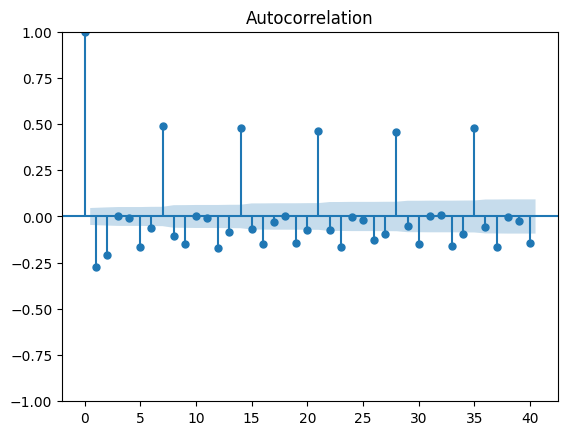

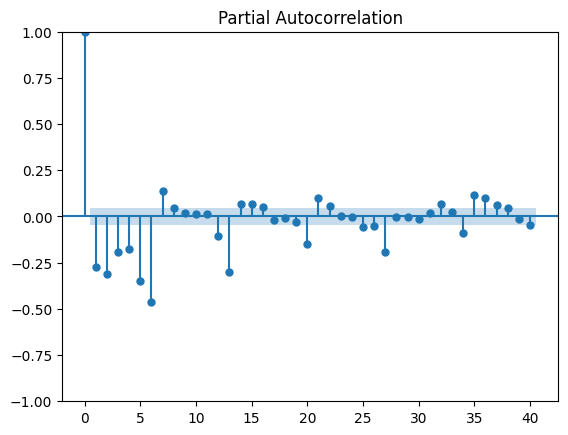

In [11]:
plot_acf(ts_diff, lags=40)
plot_pacf(ts_diff, lags=40)
plt.show()

***TRAIN-TEST SPLIT***

In [12]:
TEST_DAYS = 90
train = ts.iloc[:-TEST_DAYS]['crime_count']
test  = ts.iloc[-TEST_DAYS:]['crime_count']

***ARIMA***

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


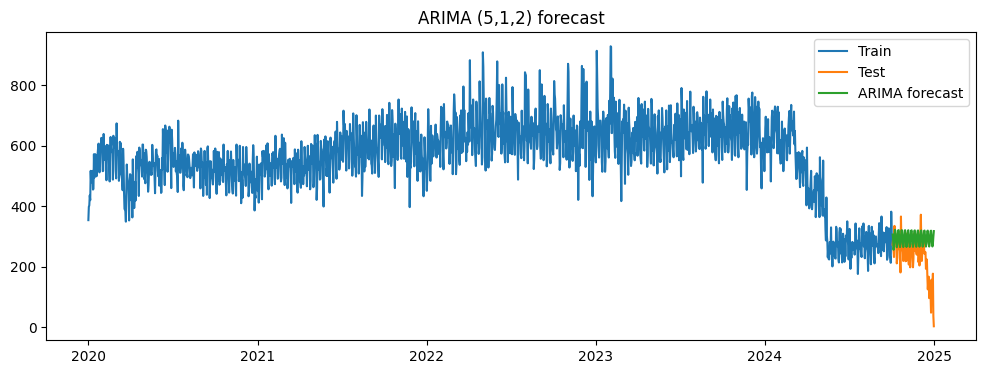

In [13]:
arima_model = ARIMA(train, order=(5, d, 2))
arima_res = arima_model.fit()
arima_fc = arima_res.forecast(steps=TEST_DAYS)

plt.figure(figsize=(12,4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index,  test,  label='Test')
plt.plot(test.index,  arima_fc, label='ARIMA forecast')
plt.legend(); plt.title('ARIMA (5,1,2) forecast'); plt.show()

***ARIMAX***

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


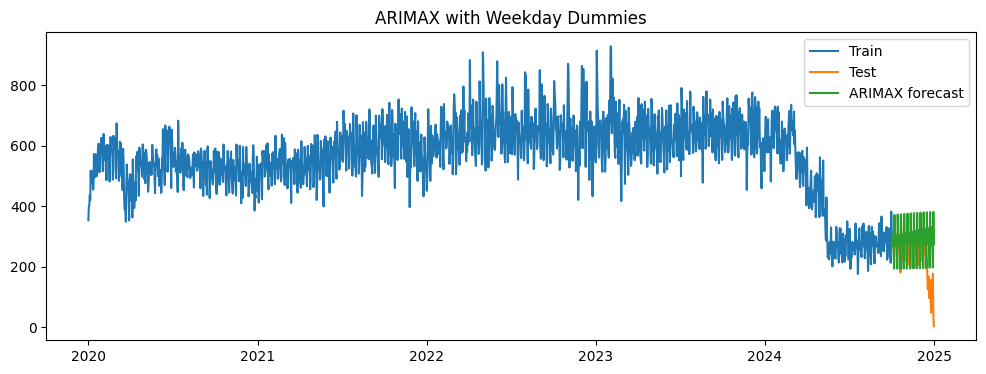

In [16]:
weekday = pd.Series(ts.index.weekday, index=ts.index, name='dow')
X = pd.get_dummies(weekday, prefix='dow', drop_first=True)

train_exog = X.loc[train_endog.index]
test_exog  = X.loc[test_endog.index]

model   = ARIMA(train_endog, exog=train_exog, order=(5, 1, 2))
result  = model.fit()

fc = result.get_forecast(steps=TEST_DAYS, exog=test_exog)
arimax_forecast = fc.predicted_mean

plt.figure(figsize=(12,4))
plt.plot(train_endog.index, train_endog, label='Train')
plt.plot(test_endog.index,  test_endog,  label='Test')
plt.plot(test_endog.index,  arimax_forecast, label='ARIMAX forecast')
plt.legend(); plt.title('ARIMAX with Weekday Dummies'); plt.show()

***SARIMA***

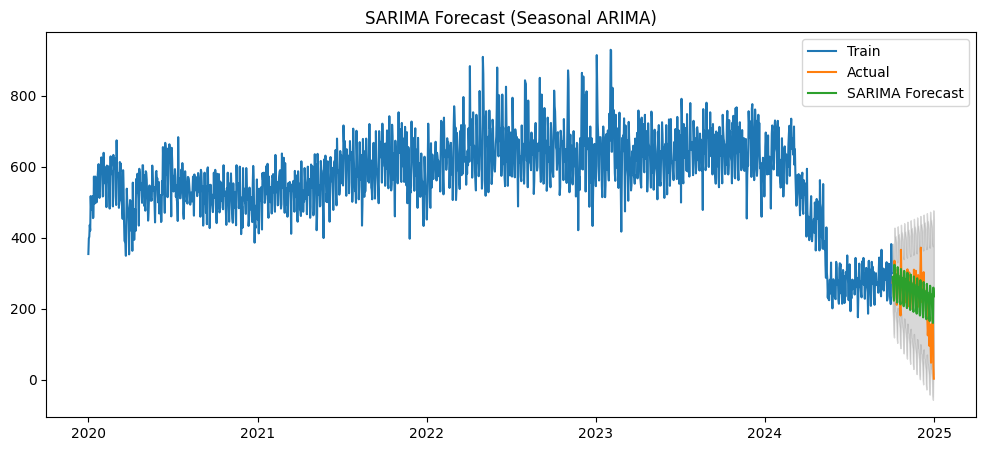

In [17]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)
result = model.fit()

forecast = result.get_forecast(steps=TEST_DAYS)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, pred_mean, label='SARIMA Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.title('SARIMA Forecast (Seasonal ARIMA)')
plt.legend()
plt.show()

***SARIMAX***

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


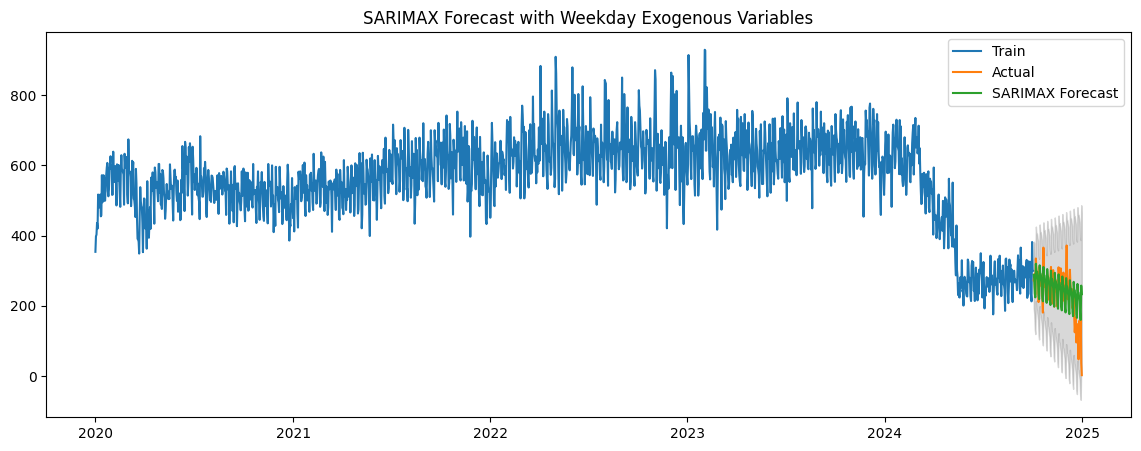

In [32]:
weekday = pd.Series(ts.index.weekday, index=ts.index, name='dow')
X = pd.get_dummies(weekday, prefix='dow', drop_first=True).astype(float)

train_exog = X.iloc[:-TEST_DAYS]
test_exog  = X.iloc[-TEST_DAYS:]

sarimax_model = SARIMAX(
    train,
    exog=train_exog,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_result.get_forecast(steps=TEST_DAYS, exog=test_exog)
sarimax_pred = sarimax_forecast.predicted_mean
sarimax_ci = sarimax_forecast.conf_int()

plt.figure(figsize=(14, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarimax_pred, label='SARIMAX Forecast')
plt.fill_between(test.index, sarimax_ci.iloc[:, 0], sarimax_ci.iloc[:, 1], color='gray', alpha=0.3)
plt.title("SARIMAX Forecast with Weekday Exogenous Variables")
plt.legend()
plt.show()

***PROPHET***

DEBUG:cmdstanpy:input tempfile: /tmp/tmp90rxa_yj/12l_bvh4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90rxa_yj/mcbdaows.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86332', 'data', 'file=/tmp/tmp90rxa_yj/12l_bvh4.json', 'init=/tmp/tmp90rxa_yj/mcbdaows.json', 'output', 'file=/tmp/tmp90rxa_yj/prophet_model1yw0t0py/prophet_model-20250701105916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:59:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:59:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


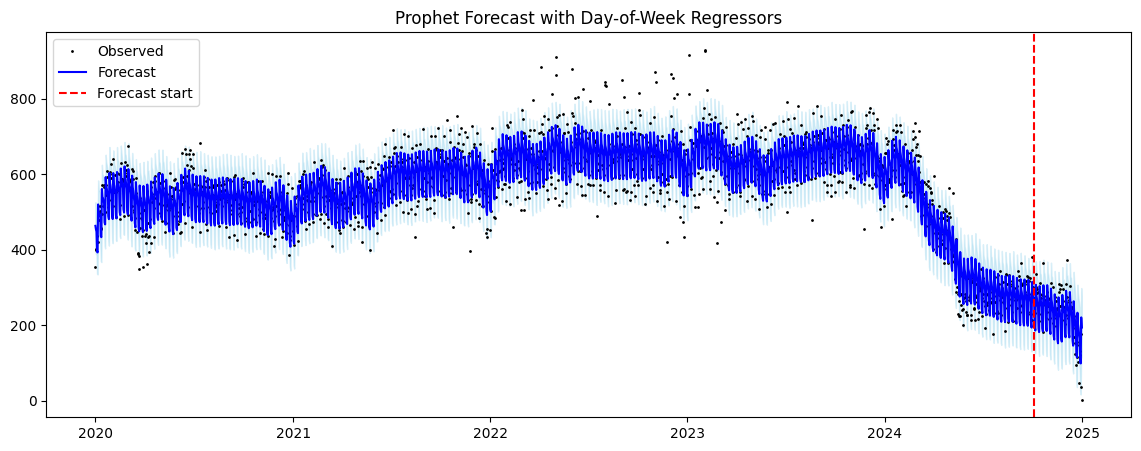

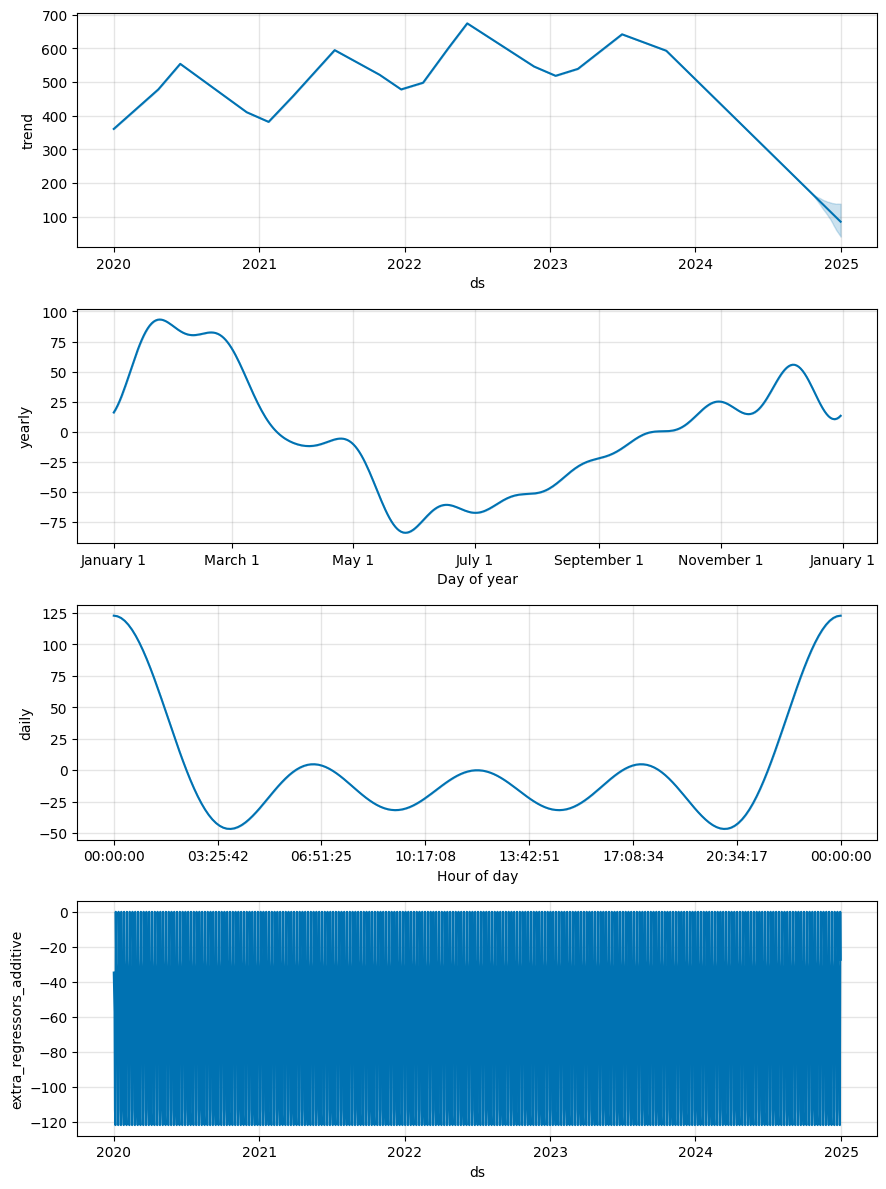

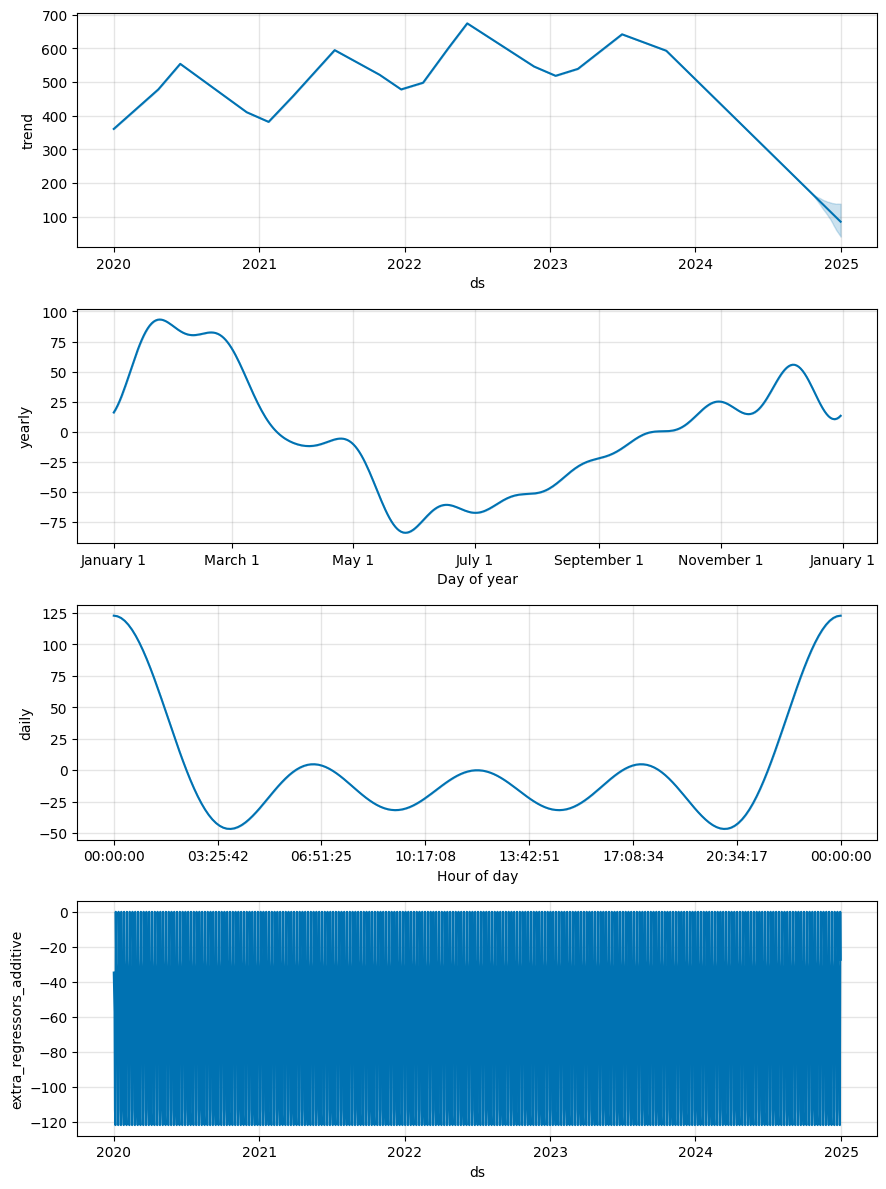

In [33]:
prophet_df = ts.reset_index().rename(columns={'date': 'ds', 'crime_count': 'y'})
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

prophet_df['dow'] = prophet_df['ds'].dt.weekday
for i in range(1, 7):
    prophet_df[f'dow_{i}'] = (prophet_df['dow'] == i).astype(float)

model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=False,
    changepoint_prior_scale=0.25
)
for i in range(1, 7):
    model.add_regressor(f'dow_{i}')

model.fit(train_df)
future = model.make_future_dataframe(periods=TEST_DAYS)
future['dow'] = future['ds'].dt.weekday
for i in range(1, 7):
    future[f'dow_{i}'] = (future['dow'] == i).astype(float)

forecast = model.predict(future)
forecast_test = forecast.tail(TEST_DAYS)

plt.figure(figsize=(14, 5))
plt.plot(prophet_df['ds'], prophet_df['y'], 'k.', markersize=2, label='Observed')
plt.plot(forecast['ds'], forecast['yhat'], 'b-', label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.axvline(x=test_df['ds'].iloc[0], color='red', linestyle='--', label='Forecast start')
plt.title("Prophet Forecast with Day-of-Week Regressors")
plt.legend()
plt.show()

model.plot_components(forecast)

***METRICS EVALUATION***

In [35]:
ts = (
    df.groupby(df['Date_Rptd'].dt.date)
    .size()
    .rename_axis('date')
    .to_frame('crime_count')
    .asfreq('D')
    .fillna(method='ffill')
)

def adf_test(series, title=''):
    stat, p, *_ = adfuller(series.dropna())
    print(f"{title} – ADF stat: {stat:.3f}, p-value: {p:.3g}")
    return p

p_val = adf_test(ts['crime_count'], 'Original Series')
if p_val > 0.05:
    ts_diff = ts['crime_count'].diff().dropna()
    adf_test(ts_diff, '1st Difference')
    d = 1
else:
    ts_diff = ts['crime_count']
    d = 0

TEST_DAYS = 90
train = ts.iloc[:-TEST_DAYS]['crime_count']
test  = ts.iloc[-TEST_DAYS:]['crime_count']

def evaluate_model(y_true, y_pred, name):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

    print(f"\n📊 {name} Performance:")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"MAPE = {mape:.2f}%")

    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

results = []

arima_model = ARIMA(train, order=(5, d, 2))
arima_res = arima_model.fit()
arima_fc = arima_res.forecast(steps=TEST_DAYS)
results.append(evaluate_model(test, arima_fc, "ARIMA"))

sarima_model = SARIMAX(train, order=(1, d, 1), seasonal_order=(1, 0, 1, 7))
sarima_res = sarima_model.fit()
sarima_fc = sarima_res.forecast(steps=TEST_DAYS)
results.append(evaluate_model(test, sarima_fc, "SARIMA"))

weekday = pd.Series(ts.index.weekday, index=ts.index, name='dow')
X = pd.get_dummies(weekday, prefix='dow', drop_first=True)

train_exog = X.loc[train.index]
test_exog  = X.loc[test.index]

arimax_model = ARIMA(train, order=(5, d, 2), exog=train_exog)
arimax_res = arimax_model.fit()
arimax_fc = arimax_res.forecast(steps=TEST_DAYS, exog=test_exog)
results.append(evaluate_model(test, arimax_fc, "ARIMAX"))

sarimax_model = SARIMAX(train, order=(5, d, 2), seasonal_order=(0, 0, 0, 0), exog=train_exog)
sarimax_res = sarimax_model.fit()
sarimax_fc = sarimax_res.forecast(steps=TEST_DAYS, exog=test_exog)
results.append(evaluate_model(test, sarimax_fc, "SARIMAX"))

prophet_df = ts.reset_index().rename(columns={'date': 'ds', 'crime_count': 'y'})
prophet_df['dow'] = pd.to_datetime(prophet_df['ds']).dt.weekday
for i in range(1, 7):
    prophet_df[f'dow_{i}'] = (prophet_df['dow'] == i).astype(float)

train_df = prophet_df.iloc[:-TEST_DAYS]
test_df = prophet_df.iloc[-TEST_DAYS:]

model = Prophet()
for i in range(1, 7):
    model.add_regressor(f'dow_{i}')
model.fit(train_df)

future = model.make_future_dataframe(periods=TEST_DAYS)
future['dow'] = future['ds'].dt.weekday
for i in range(1, 7):
    future[f'dow_{i}'] = (future['dow'] == i).astype(float)

forecast = model.predict(future)
forecast_test = forecast.tail(TEST_DAYS)
results.append(evaluate_model(test_df['y'], forecast_test['yhat'], "Prophet"))

comparison_df = pd.DataFrame(results)
print("\n📈 Model Comparison:")
display(comparison_df.set_index('Model').style.highlight_min(color='lightgreen', axis=0))

/tmp/ipython-input-35-1875856429.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


Original Series – ADF stat: 0.428, p-value: 0.983
1st Difference – ADF stat: -11.361, p-value: 9.46e-21


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 ARIMA Performance:
MAE  = 64.51
RMSE = 88.73
MAPE = 160.83%

📊 SARIMA Performance:
MAE  = 37.72
RMSE = 58.33
MAPE = 113.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 ARIMAX Performance:
MAE  = 64.90
RMSE = 91.05
MAPE = 146.17%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90rxa_yj/sua3y3ow.json



📊 SARIMAX Performance:
MAE  = 64.90
RMSE = 91.05
MAPE = 146.17%


DEBUG:cmdstanpy:input tempfile: /tmp/tmp90rxa_yj/3o7djmo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83001', 'data', 'file=/tmp/tmp90rxa_yj/sua3y3ow.json', 'init=/tmp/tmp90rxa_yj/3o7djmo_.json', 'output', 'file=/tmp/tmp90rxa_yj/prophet_modelnoa_lcop/prophet_model-20250701111237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:12:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📊 Prophet Performance:
MAE  = 82.69
RMSE = 92.23
MAPE = 71.67%

📈 Model Comparison:


,MAE,RMSE,MAPE
Model,,,
ARIMA,64.505962,88.726636,160.830111
SARIMA,37.723849,58.328678,113.169669
ARIMAX,64.896290,91.054391,146.169880
SARIMAX,64.896290,91.054391,146.169880
Prophet,82.686688,92.230882,71.668029
